# 🚦 Traffic Sign Recognition  
## ARI711S Project 1 – Part 3  

**Objective**:  
Train a Convolutional Neural Network (CNN) to classify German traffic signs using the GTSRB dataset.
- Input image size: `30×30`
- Total classes: `43`
- Output: Saved model (`model.h5`) + evaluation


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, LeakyReLU

np.random.seed(42)
tf.random.set_seed(42)

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU enabled")
else:
    print("Using CPU")


Using CPU


## Load and Preprocess Data

- Read images from `gtsrb/` directory
- Resize to `30×30`
- Normalize pixel values
- Visualize some sample traffic signs


Loading 30x30 images from gtsrb...


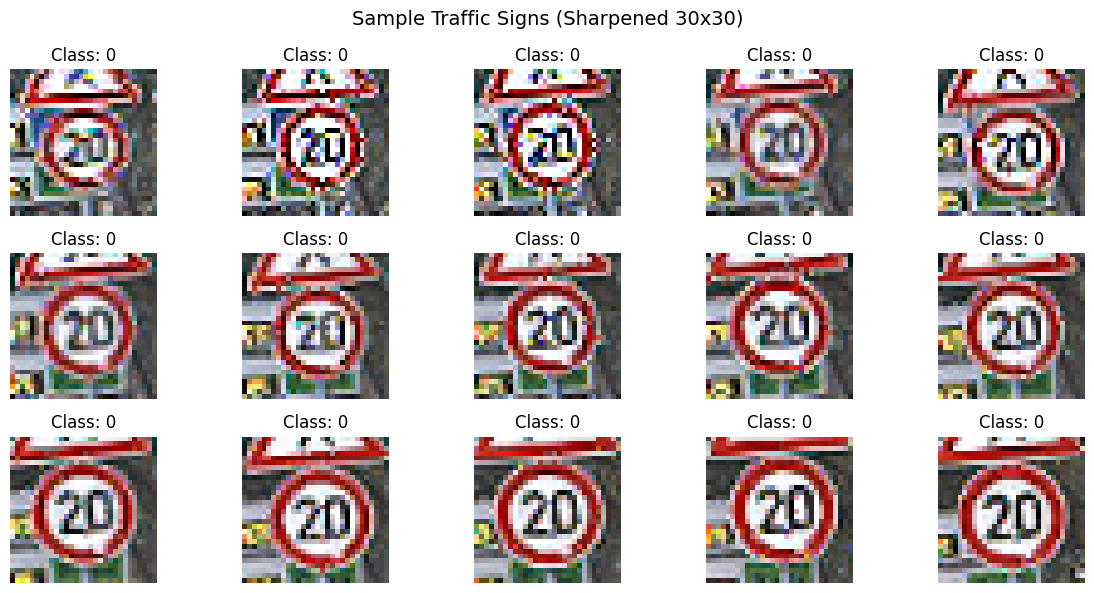

In [3]:
def sharpen_image(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def load_data(data_dir, img_size=(30, 30)):
    images, labels = [], []
    print(f"Loading {img_size[0]}x{img_size[1]} images from {data_dir}...")

    for label in range(43):
        class_dir = os.path.join(data_dir, str(label))
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = sharpen_image(img)
                img = cv2.cvtColor(cv2.resize(img, img_size), cv2.COLOR_BGR2RGB) / 255.0
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)

# Load data
data_dir = "gtsrb"
X, y = load_data(data_dir, img_size=(30, 30))

plt.figure(figsize=(12, 6))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(X[i])
    plt.title(f"Class: {y[i]}")
    plt.axis('off')
plt.suptitle("Sample Traffic Signs (Sharpened 30x30)", fontsize=14)
plt.tight_layout()
plt.show()

## Build CNN Model

- 2 convolutional layers
- MaxPooling
- Flatten + Dense + Dropout
- Final softmax layer (43 classes)


In [5]:
def build_enhanced_cnn(input_shape=(30, 30, 3), num_classes=43):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(),
        LeakyReLU(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256),
        LeakyReLU(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_enhanced_cnn()
model.summary()

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 15, 15, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 15, 15, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 15, 15, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         803,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 880,459 (3.36 MB)

 Trainable params: 880,075 (3.36 MB)

 Non-trainable params: 384 (1.50 KB)

## 3: Train the Model

- Use 80/20 train-test split
- 15 epochs
- Batch size = 32


## 4: Plot Training Accuracy & Loss


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X_train)

In [9]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=15,
                    validation_data=(X_test, y_test))

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
666/666 ━━━━━━━━━━━━━━━━━━━━ 120s 145ms/step - accuracy: 0.3219 - loss: 2.8562 - val_accuracy: 0.8947 - val_loss: 0.3307
Epoch 2/15
666/666 ━━━━━━━━━━━━━━━━━━━━ 96s 144ms/step - accuracy: 0.8126 - loss: 0.5861 - val_accuracy: 0.9675 - val_loss: 0.1111
Epoch 3/15
666/666 ━━━━━━━━━━━━━━━━━━━━ 93s 139ms/step - accuracy: 0.9020 - loss: 0.3066 - val_accuracy: 0.9737 - val_loss: 0.0860
Epoch 4/15
666/666 ━━━━━━━━━━━━━━━━━━━━ 92s 137ms/step - accuracy: 0.9346 - loss: 0.2067 - val_accuracy: 0.9904 - val_loss: 0.0356
Epoch 5/15
666/666 ━━━━━━━━━━━━━━━━━━━━ 92s 139ms/step - accuracy: 0.9496 - loss: 0.1611 - val_accuracy: 0.9874 - val_loss: 0.0397
Epoch 6/15
666/666 ━━━━━━━━━━━━━━━━━━━━ 94s 141ms/step - accuracy: 0.9535 - loss: 0.1442 - val_accuracy: 0.9927 - val_loss: 0.0299
Epoch 7/15
666/666 ━━━━━━━━━━━━━━━━━━━━ 119s 178ms/step - accuracy: 0.9627 - loss: 0.1204 - val_accuracy: 0.9921 - val_loss: 0.0304
Epoch 8/15
666/666 ━━━━━━━━━━━━━━━━━━━━ 104s 155ms/step - accuracy: 0.9644 - loss

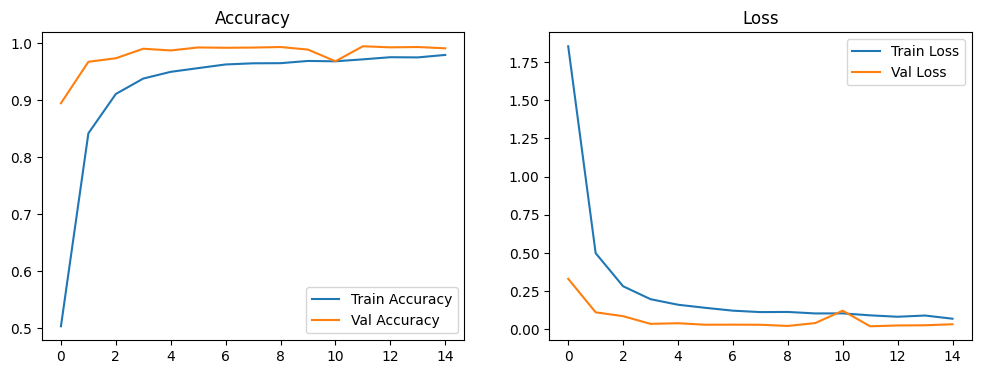

In [11]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_history(history)


## 5: Evaluate Model on Test Set

- Show accuracy
- Classification report
- Confusion matrix


Test Accuracy: 0.9912
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.99      0.98      0.98       300
           2       0.97      0.99      0.98       300
           3       1.00      0.97      0.99       192
           4       1.00      0.99      1.00       264
           5       0.97      0.99      0.98       252
           6       1.00      1.00      1.00        60
           7       0.98      0.99      0.99       192
           8       0.99      0.99      0.99       192
           9       1.00      0.96      0.98       198
          10       0.98      1.00      0.99       270
          11       1.00      0.99      0.99       180
          12       1.00      1.00      1.00       282
          13       1.00      1.00      1.00       288
          14       1.00      1.00      1.00       108
          15       1.00      1.00      1.00    

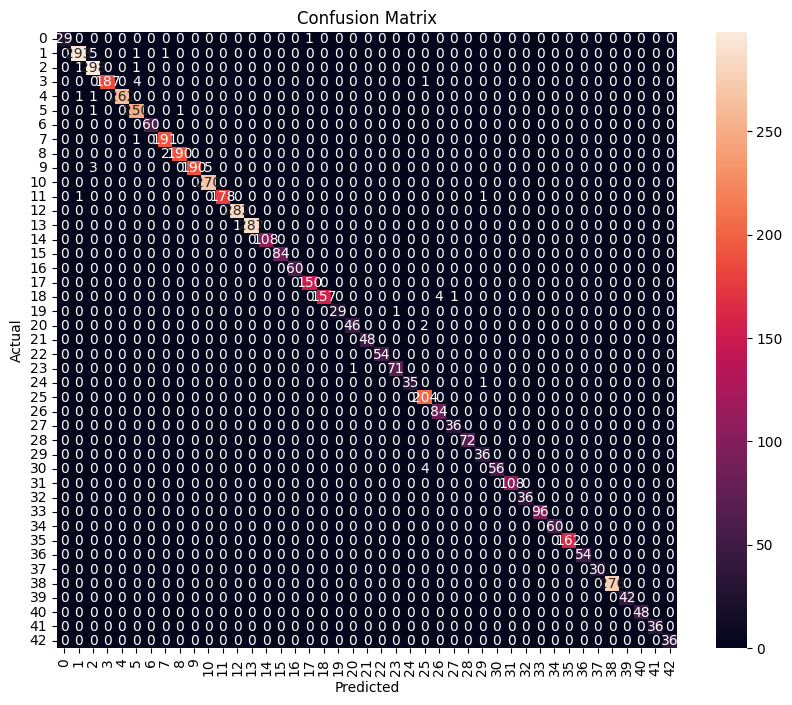

In [19]:
def evaluate_model(model, X_test, y_test):
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}")

    y_pred = np.argmax(model.predict(X_test), axis=1)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return test_acc

accuracy = evaluate_model(model, X_test, y_test)

## 6: Save Model


In [30]:
model.save("model.h5")
print("Model saved as model.h5")


Model saved as model.h5


# 🚦 Traffic Sign Recognition AI – ARI711S Project 1 (Part 3)

## Objective

Develop a Convolutional Neural Network (CNN) to classify German traffic signs using the **GTSRB dataset**.  
The goal is to train a model that achieves high classification accuracy using **30×30 pixel input images**, as specified in the project brief.

---

## What the Project Does

- Loads and preprocesses the GTSRB dataset (43 classes)
- Applies image sharpening to reduce blur
- Trains an **enhanced CNN** using TensorFlow/Keras
- Uses **batch normalization**, **LeakyReLU**, and **dropout**
- Applies **data augmentation** for better generalization
- Evaluates model performance using accuracy and confusion matrix
- Saves trained model to `model.h5` (required)
- Presents results and visualizations in a Jupyter notebook

---

## Dataset: GTSRB

- **Full Name:** German Traffic Sign Recognition Benchmark (GTSRB)
- **Structure:**  
  ```
  gtsrb/
  ├── 0/
  ├── 1/
  ├── ...
  └── 42/
  ```
- **Total Classes:** 43 traffic sign categories
- **Data Format:** JPEG images of varied size, orientation, and brightness

---

## Enhanced CNN Architecture

| Layer Type           | Output Shape | Notes                                 |
|----------------------|--------------|----------------------------------------|
| Conv2D (32)          | 30×30×32     | + BatchNormalization + LeakyReLU      |
| Conv2D (32)          | 30×30×32     | + BatchNormalization + LeakyReLU      |
| MaxPooling2D         | 15×15×32     | Downsampling                          |
| Conv2D (64)          | 15×15×64     | + BatchNormalization + LeakyReLU      |
| Conv2D (64)          | 15×15×64     | + BatchNormalization + LeakyReLU      |
| MaxPooling2D         | 7×7×64       | Downsampling                          |
| Flatten              | -            | Converts to vector                    |
| Dense (256)          | 256          | Fully connected + LeakyReLU           |
| Dropout (0.5)        | -            | Prevents overfitting                  |
| Output (Softmax)     | 43           | One output per class                  |

---

## Results

| Metric        | Value     |
|---------------|-----------|
| **Test Accuracy** | `99.12%`  |
| **Epochs**        | 15        |
| **Batch Size**    | 32        |
| **Loss**          | `sparse_categorical_crossentropy` |
| **Optimizer**     | `Adam`    |

---

### Confusion Matrix & Classification Report

- Visualized using `seaborn`'s heatmap
- Clearly shows true vs predicted labels
- Achieved **very high precision and recall** across most classes

---

## Conclusion
Our project demonstrates an effective deep learning pipeline for real-world image classification.  
The enhanced CNN achieved a **test accuracy of 99.12%**, significantly exceeding the target accuracy of 95%.

To improve the model's robustness, we integrated several enhancements:
- **Sharpening filters** to improve clarity of blurry images
- **Batch normalization** for more stable and faster training
- **LeakyReLU activations** to prevent dead neurons
- **Data augmentation** to improve generalization on unseen data

Initially, we experimented with **ResNet50**, a powerful pre-trained convolutional model. While it showed promise during testing, it required significant computational resources. On our systems, training ResNet50 caused memory crashes and performance issues. Additionally, we chose to focus on building a custom CNN from scratch, in line with the project’s educational objectives. Avoiding ResNet50 also ensured that our model was not dependent on pretrained architectures, reinforcing our understanding of fundamental CNN design.

Ultimately, we prioritized performance, interpretability, and project compliance resulting in a high-performing and well-explained traffic sign classifier.

---
## Authors

**Ismael Mudjanima, Mitchum Winston Janaurie, Anna Shingo, and Kelvin Gora**  
Namibia University of Science and Technology  
Module: ARI711S Artificial Intelligence  
Submission: Project 1 – Part 3  
April 2025